<a href="https://colab.research.google.com/github/Naveenand/Computer-vision/blob/main/Tuberculosis_image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 kaggle.json
!kaggle datasets download -d tawsifurrahman/tuberculosis-tb-chest-xray-dataset

100% 663M/663M [00:35<00:00, 19.4MB/s]
100% 663M/663M [00:35<00:00, 19.5MB/s]


In [ ]:
!unzip /content/tuberculosis-tb-chest-xray-dataset.zip

In [ ]:
from shutil import copyfile
import urllib.request
import os
import zipfile
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style= "darkgrid", color_codes = True)
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, Input
from keras.regularizers import l2
from tensorflow.keras.metrics import BinaryAccuracy
from sklearn.metrics import auc
from tensorflow.keras.preprocessing.image import  load_img
import warnings
warnings.filterwarnings('ignore')

In [ ]:
print("Number of Normal chest images:",len(os.listdir('/content/TB_Chest_Radiography_Database/Normal')))
print("Number of Tuberculosis images:",len(os.listdir('/content/TB_Chest_Radiography_Database/Tuberculosis')))

Number of Normal chest images: 3500
Number of Tuberculosis images: 700


In [ ]:
try:
    os.mkdir('/tmp/TB_Chest_Radiography_Database')
    os.mkdir('/tmp/TB_Chest_Radiography_Database/training')
    os.mkdir('/tmp/TB_Chest_Radiography_Database/testing')
    os.mkdir('/tmp/TB_Chest_Radiography_Database/training/Normal')
    os.mkdir('/tmp/TB_Chest_Radiography_Database/training/Tuberculosis')
    os.mkdir('/tmp/TB_Chest_Radiography_Database/testing/Normal')
    os.mkdir('/tmp/TB_Chest_Radiography_Database/testing/Tuberculosis')
except OSError:
    pass

In [ ]:
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    files = []
    for filename in os.listdir(SOURCE):
        file = os.path.join(SOURCE,filename)
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(filename + " is zero length, so ignoring.")

    training_length = int(len(files) * SPLIT_SIZE)
    testing_length = int(len(files) - training_length)
    shuffled_set = random.sample(files, len(files))
    training_set = shuffled_set[0:training_length]
    testing_set = shuffled_set[training_length:]

    for filename in training_set:
        this_file = os.path.join(SOURCE,filename)
        destination = os.path.join(TRAINING,filename)
        copyfile(this_file, destination)

    for filename in testing_set:
        this_file = os.path.join(SOURCE,filename)
        destination = os.path.join(TESTING,filename)
        copyfile(this_file, destination)


Normal_SOURCE_DIR = "/content/TB_Chest_Radiography_Database/Normal"
TRAINING_Normal_DIR = "/tmp/TB_Chest_Radiography_Database/training/Normal"
TESTING_Normal_DIR = "/tmp/TB_Chest_Radiography_Database/testing/Normal"
Tuberculosis_SOURCE_DIR = "/content/TB_Chest_Radiography_Database/Tuberculosis"
TRAINING_Tuberculosis_DIR = "/tmp/TB_Chest_Radiography_Database/training/Tuberculosis"
TESTING_Tuberculosis_DIR = "/tmp/TB_Chest_Radiography_Database/testing/Tuberculosis"

split_size = .9
split_data(Normal_SOURCE_DIR, TRAINING_Normal_DIR, TESTING_Normal_DIR, split_size)
split_data(Tuberculosis_SOURCE_DIR, TRAINING_Tuberculosis_DIR, TESTING_Tuberculosis_DIR, split_size)


In [ ]:
print("Number of training Normal chest images", len(os.listdir('/tmp/TB_Chest_Radiography_Database/training/Normal')))
print("Number of training Tuberculosis images", len(os.listdir('/tmp/TB_Chest_Radiography_Database/training/Tuberculosis')))
print("Number of testing Normal chest images", len(os.listdir('/tmp/TB_Chest_Radiography_Database/testing/Normal')))
print("Number of testing Tuberculosis images", len(os.listdir('/tmp/TB_Chest_Radiography_Database/testing/Tuberculosis')))

Number of training Normal chest images 3150
Number of training Tuberculosis images 630
Number of testing Normal chest images 350
Number of testing Tuberculosis images 70


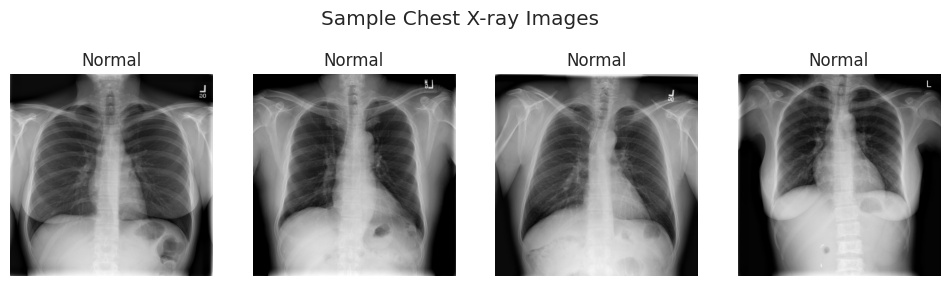

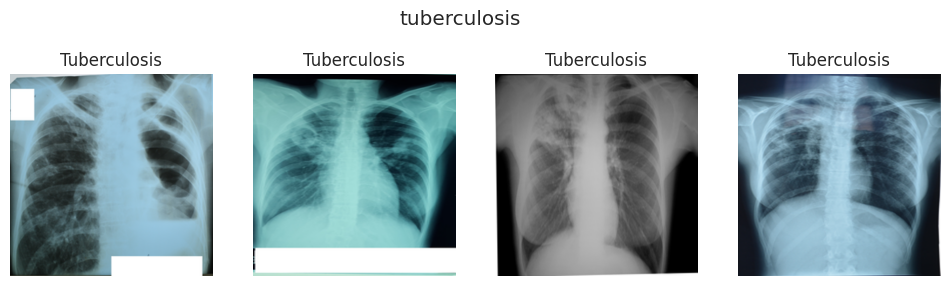

In [ ]:
import os
import cv2
import random
import matplotlib.pyplot as plt

TRAINING_DIR = "/tmp/TB_Chest_Radiography_Database/training"
normal_dir = os.path.join(TRAINING_DIR, "Normal")
tuberculosis_dir = os.path.join(TRAINING_DIR, "Tuberculosis")

# Function to display images
def display_images(image_paths, title):
    plt.figure(figsize=(12, 6))
    plt.suptitle(title)

    for i in range(4):
        plt.subplot(2, 4, i + 1)
        img = cv2.imread(image_paths[i])
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title("Normal" if "Normal" in image_paths[i] else "Tuberculosis")
        plt.axis('off')

# List images in the "Normal" and "Tuberculosis" directories
normal_images = [os.path.join(normal_dir, filename) for filename in os.listdir(normal_dir)][:4]
tuberculosis_images = [os.path.join(tuberculosis_dir, filename) for filename in os.listdir(tuberculosis_dir)][:4]

# Shuffle the image lists
random.shuffle(normal_images)
random.shuffle(tuberculosis_images)

# Display the images
display_images(normal_images + tuberculosis_images, "Sample Chest X-ray Images")
display_images( tuberculosis_images, "tuberculosis")
plt.show()


# Data preprocessing

In [ ]:
TRAINING_DIR = "/tmp/TB_Chest_Radiography_Database/training/"

train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=40,
                                width_shift_range=0.2,
                               height_shift_range=0.2,
                                     shear_range=0.2,
                                       zoom_range=0.2,
                                  horizontal_flip=True,
                                   fill_mode='nearest')
train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size=100,
                                                    class_mode='binary',
                                                    target_size=(150, 150))

VALIDATION_DIR = "/tmp/TB_Chest_Radiography_Database/testing/"

validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                              batch_size=100,
                                                              class_mode='binary',
                                                              target_size=(150, 150))


Found 3780 images belonging to 2 classes.
Found 420 images belonging to 2 classes.


#Model building

58889256/58889256 [==============================] - 4s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 128)               1048704   
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 15763521 (60.13 MB)
Trainable params: 8128257 (31.01 MB)
Non-trainable params: 7635264 (29.13 MB)
_________________________________________________________________


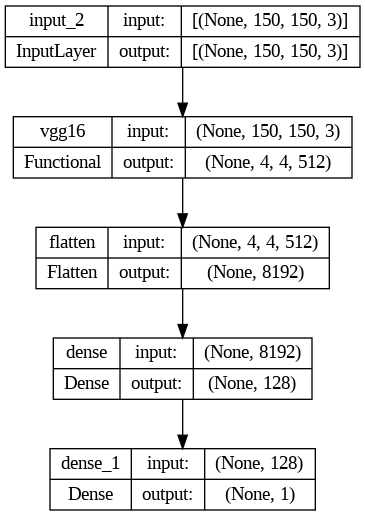

In [ ]:
# We use transfer learning with VGG16 as the base model
def CNN_Model():
    base_model = VGG16(weights='imagenet', include_top = False, input_shape=(150, 150, 3))
    # Freeze the base model
    for layer in base_model.layers:
        layer.trainable = False

    for i in range(3):
        base_model.layers[-2-i].trainable = True

    CNN = Sequential()
    CNN.add(Input(shape=(150, 150,3)))
    CNN.add(base_model)
    CNN.add(Flatten())
    CNN.add(Dense(128, activation='relu', kernel_regularizer=l2(0.05)))
    CNN.add(Dense(1, activation='sigmoid'))

    return CNN

# Training The CNN
model = CNN_Model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()
# Visualized Layers of CNN
keras.utils.plot_model(model, show_shapes=True)

#Model Traning

In [ ]:
hist = model.fit(
     train_generator,
     validation_data=validation_generator,
     epochs=5,
    verbose=1
)

Epoch 1/5
38/38 [==============================] - 82s 2s/step - loss: 3.5822 - accuracy: 0.8471 - val_loss: 0.9119 - val_accuracy: 0.8429
Epoch 2/5
38/38 [==============================] - 58s 2s/step - loss: 0.3881 - accuracy: 0.9455 - val_loss: 0.2311 - val_accuracy: 0.9238
Epoch 3/5
38/38 [==============================] - 59s 2s/step - loss: 0.1472 - accuracy: 0.9696 - val_loss: 0.0862 - val_accuracy: 0.9810
Epoch 4/5
38/38 [==============================] - 60s 2s/step - loss: 0.1117 - accuracy: 0.9706 - val_loss: 0.0759 - val_accuracy: 0.9786
Epoch 5/5
38/38 [==============================] - 57s 1s/step - loss: 0.0934 - accuracy: 0.9743 - val_loss: 0.0464 - val_accuracy: 0.9929


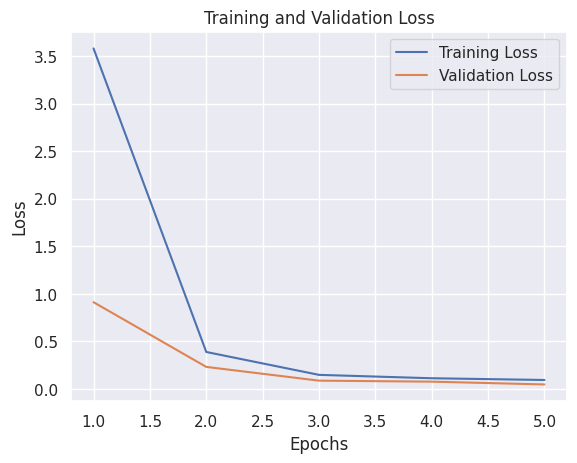

In [ ]:
# Extract the training and validation loss values from the history object
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']

# Create a list of epoch numbers (1 to number of epochs)
epochs = range(1, len(train_loss) + 1)

# Plot the loss graph
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

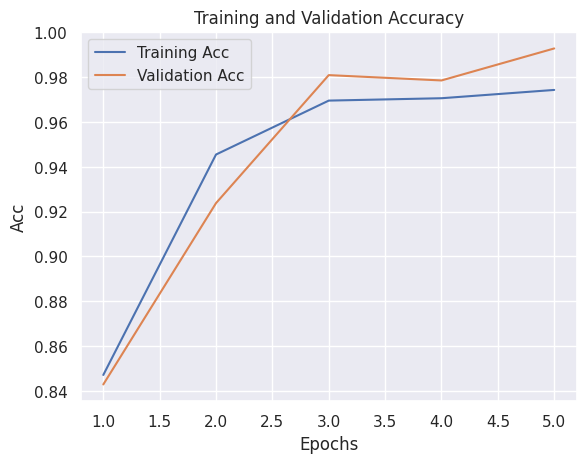

In [ ]:
# Extract the training and validation loss values from the history object
train_accuracy = hist.history['accuracy']
val_accuracy = hist.history['val_accuracy']

# Create a list of epoch numbers (1 to number of epochs)
epochs = range(1, len(train_accuracy) + 1)

# Plot the loss graph
plt.plot(epochs, train_accuracy , label='Training Acc')
plt.plot(epochs, val_accuracy, label='Validation Acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.grid(True)
plt.show()